<a href="https://colab.research.google.com/github/Hackathorn/WILS-NEURIPS22/blob/master/notebooks/WILS-NEURIPS22-DataPrep-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Localized Manifords

...Using NEURIPS22 Paper Abstracts. Derived from the Cohere Dashboard at https://dashboard.cohere.ai/playground/embed. A sample of 33 NEURIPS22 accepted papers (title + abstract) were extracted.

## Configure

In [1]:
%pip install -Uqqq cohere chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.7/966.7 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.0 MB/s 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import cohere
import chromadb as db

## Load and embed data

In [3]:
# upload repo locally
!rm -rf /content/WILS-NEURIPS22
!git clone https://github.com/Hackathorn/WILS-NEURIPS22.git

Cloning into 'WILS-NEURIPS22'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 67 (delta 25), reused 44 (delta 13), pack-reused 0
Unpacking objects: 100% (67/67), 592.88 KiB | 6.66 MiB/s, done.


In [5]:
# create list of abstracts to embed
with open("./WILS-NEURIPS22/doc/NEURIPS22-abstract-sample-UTF8.txt",   # for Colab
# with open("../doc/NEURIPS22-abstract-sample-UTF8.txt",  # for VScode
          encoding='utf-8', errors='ignore') as f:
    abstracts = f.readlines()

# ...plus their paper titles
titles = [a.split('.')[0].strip() for a in abstracts]

In [6]:
titles[:10]


['On Kernel-Target Alignment',
 'On the Convergence of Prior-Guided Zeroth-Order Optimization Algorithms',
 'Communication Complexity of Distributed Convex Learning and Optimization',
 'Straggler Mitigation in Distributed Optimization Through Data Encoding',
 'Finite Sample Convergence Rates of Zero-Order Stochastic Optimization Methods',
 'Efficient Pure Exploration in Adaptive Round model',
 'On Top-k Selection in Multi-Armed Bandits and Hidden Bipartite Graphs',
 'MaxGap Bandit: Adaptive Algorithms for Approximate Ranking',
 'A Smoothed Analysis of the Greedy Algorithm for the Linear Contextual Bandit Problem',
 'Identifying Outlier Arms in Multi-Armed Bandit']

In [7]:
# generate embeddings for abstracts
co = cohere.Client('9UQ2FJ61TaGMhZKBoiY7JeGa23qlEyPqmpNjER97') # This is your trial API key
response = co.embed(
  model='embed-english-v2.0',
  texts=abstracts,
)
# convert to np.array
embeddings = np.array(response.embeddings)

# show stats on embeddings
print(embeddings.shape)
print(embeddings.min())
print(embeddings.max())
print(embeddings.mean())
print(embeddings.std())


(33, 4096)
-9.9375
10.8828125
-0.0009693962722598167
1.2779840980922614


## Store embeddings into Chroma

In [8]:
# Create collection and add all the embeddings
client = db.Client()
collection = client.create_collection(name="NEURIPS22")
collection.add(
    documents=titles,
    ids=[f'id{i+1}' for i in range(len(titles))],
    embeddings=response.embeddings,
)

In [9]:
# get a few embeddings
collection.get(
    ids=['id1', 'id4', 'id23'],
)

{'ids': ['id1', 'id4', 'id23'],
 'embeddings': None,
 'documents': ['On Kernel-Target Alignment',
  'Straggler Mitigation in Distributed Optimization Through Data Encoding',
  'Active Information Retrieval'],
 'metadatas': [None, None, None]}

## Find the clusters using Kmeans
...for various number of clusters

Trying various methods (with help from ChatGPT)

In [15]:
# Assuming you have a list of 33 objects with their corresponding 4096-dimensional vectors
# objects = [...]  # Replace [...] with your actual object list

# Define the range of clusters to try
min_clusters = 3
max_clusters = 10

# For different cluster numbers,
# calculate within-cluster sum of squares (WCSS) and silhouette score
label_list = []
cluster_sizes = []
wcss_list = []
score_list = []

# loop thru various clusters
for num_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
    kmeans.fit(embeddings)

    label_list.append(kmeans.labels_)
    cluster_sizes.append(num_clusters)
    wcss_list.append(kmeans.inertia_)
    score_list.append(silhouette_score(embeddings, kmeans.labels_))


Elbow Method: The elbow method helps identify the number of clusters by plotting the within-cluster sum of squares (WCSS) against the number of clusters. The idea is to look for a point on the plot where adding more clusters does not significantly decrease the WCSS. This point resembles an elbow, hence the name. You can use the KMeans inertia_ attribute to calculate the WCSS.

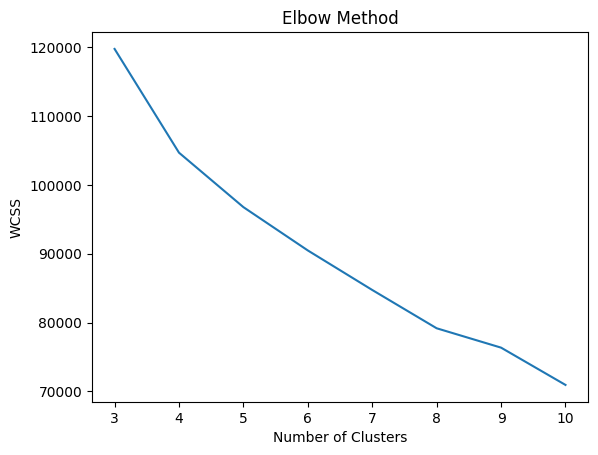

In [16]:
# Plot the WCSS values against the number of clusters
plt.plot(range(min_clusters, max_clusters + 1), wcss_list)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

Silhouette Score: The silhouette score measures the quality of a clustering solution based on both the cohesion within clusters and the separation between clusters. Higher silhouette scores indicate better-defined clusters. You can use the silhouette_score function from the sklearn.metrics module to compute the silhouette score.

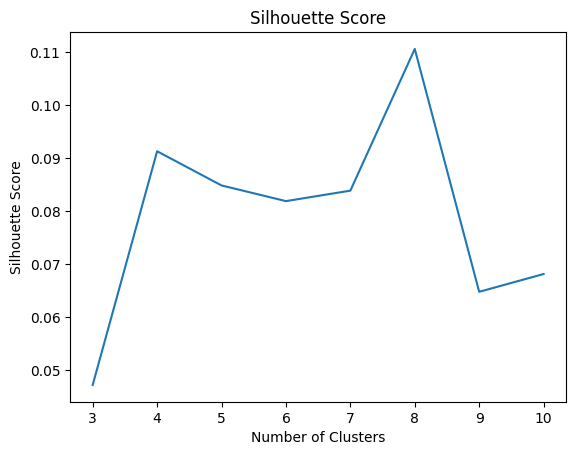

In [17]:
# Plot the silhouette scores against the number of clusters
plt.plot(range(min_clusters, max_clusters + 1), score_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

## Calculate PCA stats on the best clustering

From the Kmeans plots, Clusters 7, 4, 3 are the best  
...TODO: cycle thru all possible cluster sizes

In [27]:
# choose cluster size = 7
i = cluster_sizes.index(7)
labels = label_list[i]
i, labels

(4,
 array([0, 0, 0, 0, 0, 5, 1, 1, 5, 1, 5, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4,
        4, 4, 4, 4, 2, 4, 4, 4, 4, 3, 3], dtype=int32))

In [34]:
# for each cluster, create list of embeddings for that cluster
cluster_embeds = []

for i in range(max(labels)):
    indices = [k for k, j in enumerate(labels) if j == i]
    embeds = embeddings[indices]
    cluster_embeds.append(embeds)
    # print(i, indices, len(embeds))

0 [0, 1, 2, 3, 4] 5
1 [6, 7, 9] 3
2 [26] 1
3 [31, 32] 2
4 [19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30] 11
5 [5, 8, 10] 3


In [51]:
# calculate mean and std for each cluster
for c in range(len(cluster_embeds)):
    embs = cluster_embeds[c]
    means = np.mean(embs, axis=0)
    stds = np.std(embs, axis=0)

    print(len(embs), stds[0], stds.mean(), stds.std())


5 0.809164067668155 0.780506699577213 0.3322202210372701
3 0.36329172086164535 0.5850779521503449 0.31851734673634857
1 0.0 0.0 0.0
2 0.34234619 0.48764911470409666 0.38624802997251
11 0.9018749765559028 0.7859739668514392 0.23921500588362038
3 0.6437450557872944 0.6592092172537513 0.36862165366045446


In [56]:
embs = cluster_embeds[4]
len(embs)

11

In [66]:
from sklearn.decomposition import PCA

def find_plot_PCA(embs):

    # check if no of vectors < 3 => trival results
    if len(embs) < 3:
        return

    # 1. Get the principal components
    pca = PCA()
    pca.fit(embs)

    # 2. Get the eigenvalues and eigenvectors
    eigenvalues = pca.explained_variance_ratio_
    eigenvectors = pca.components_

    # 3. Print the PCA stats
    print(f"Number of Components: {pca.n_components_}")
    print("Eigenvalues:")
    for eigenvalue in eigenvalues[:3]:
        print(eigenvalue)

    # print("Eigenvectors:")
    # for eigenvector in eigenvectors:
    #     print(eigenvector)

    # 4. Plot the cumulative variance explained
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.show()

    # 5. Plot the Dim-Reduction Points
    plt.scatter(eigenvectors[:, 0], eigenvectors[:, 1])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

Number of Components: 5
Eigenvalues:
0.3704002311744673
0.27042200007438555
0.18581924471968644


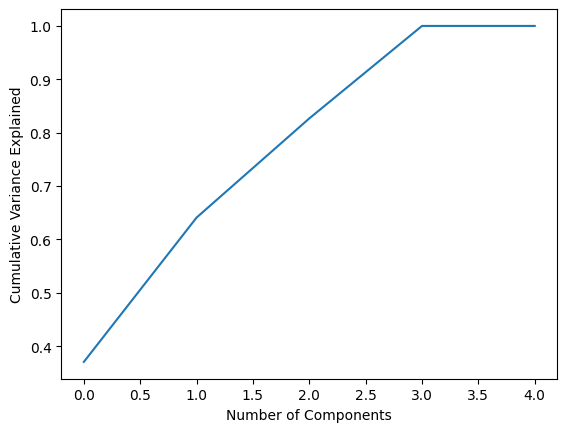

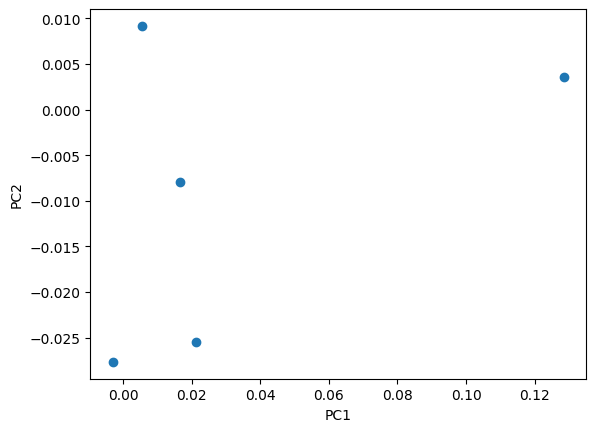

Number of Components: 3
Eigenvalues:
0.5448209713710235
0.4551790286289765
3.7813870158744444e-31


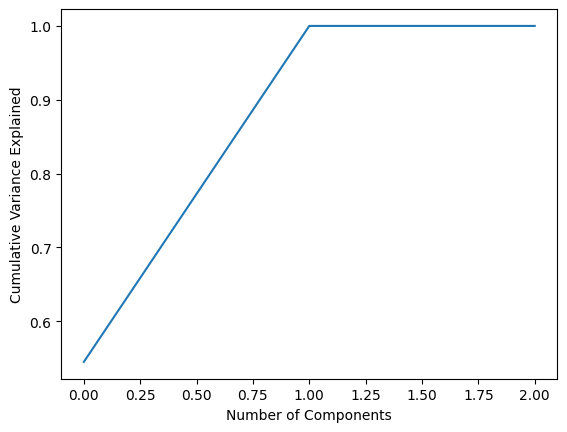

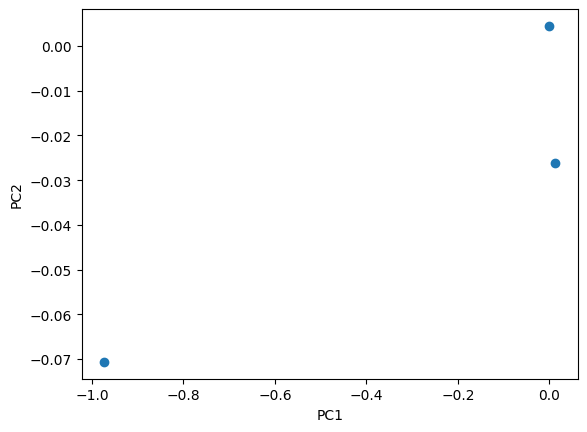

Number of Components: 11
Eigenvalues:
0.187978750817552
0.15382333733568418
0.13823092252858085


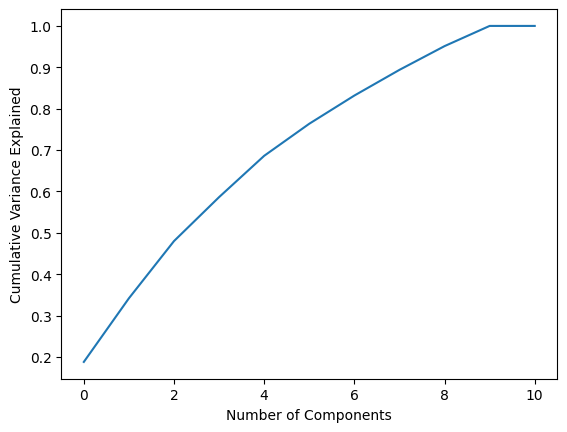

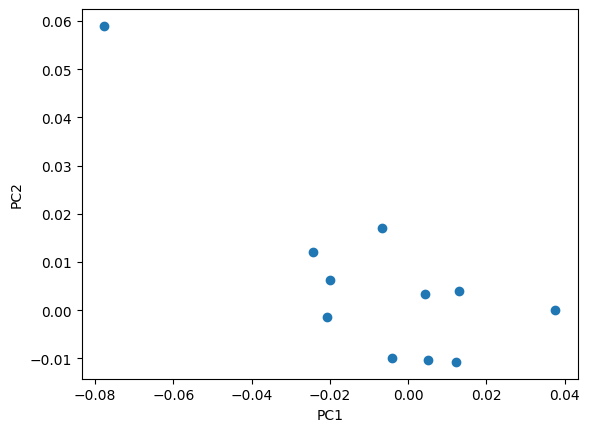

Number of Components: 3
Eigenvalues:
0.587472948549776
0.4125270514502239
1.3811352973505237e-30


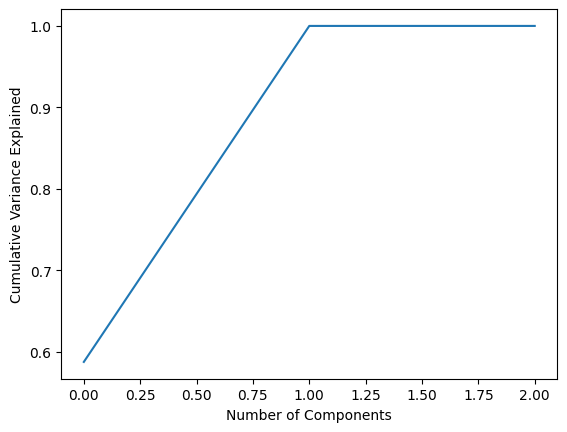

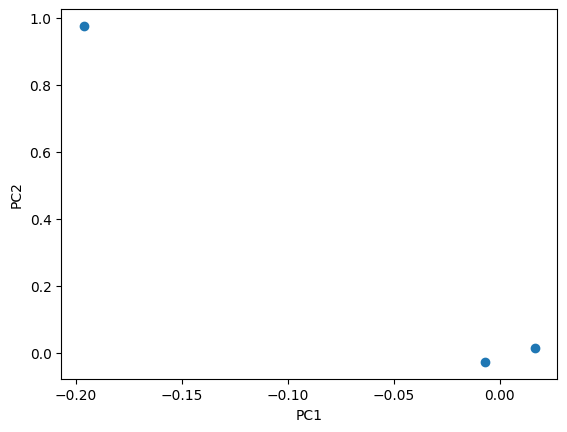

In [67]:
for embs in cluster_embeds:
    find_plot_PCA(embs)

In [ ]:
# prompt: given PCA fit, plot the cumulative variance explained

# 1. Fit the PCA model
pca = PCA()
pca.fit(embs)

# 2. Get the eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_ratio_
eigenvectors = pca.components_

# 3. Print the PCA stats
print(f"Number of Components: {pca.n_components_}")
print("Eigenvalues:")
for eigenvalue in eigenvalues:
    print(eigenvalue)

print("Eigenvectors:")
for eigenvector in eigenvectors:
    print(eigenvector)

# 4. Plot the cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.show()

## Using UMAP to find clusters

In [ ]:
!pip install -qq umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -qq umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import umap

In [ ]:
# prompt: use UMAP to find clusters in embeddings without reducing dimensionality, given mapping of abstracts to cluster_ids

# find cluster IDs for each abstract
clusterer = umap.UMAP(n_neighbors=100, min_dist=0.1, )
cluster_ids = clusterer.fit
# cluster_ids = clusterer.fit_predict(embeddings)

# plot UMAP embedding of abstracts, colored by cluster ID
plt.figure(figsize=(12, 12))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=cluster_ids, palette="tab10")
plt.title("UMAP Embedding of Abstracts")
plt.show()

In [ ]:
cluster_ids


<bound method UMAP.fit of UMAP(n_neighbors=100)>

In [ ]:
use UMAP to find clusters in embeddings without reducing dimensionality, given mapping of abstracts to cluster_ids


SyntaxError: ignored

In [ ]:
# prompt: Using UMAP, find the clusters in embeddings

import umap

reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(embeddings, )


In [ ]:
# prompt: plot the clusters in embedding_map

plt.scatter(*embedding_umap.T, c=response.cluster_ids, cmap='tab10')
plt.title('UMAP visualization of document clusters')
plt.show()

AttributeError: ignored